In [1]:
import sys

sys.path.append("../")  # make modules in repo root available

In [6]:
import random

import cv2
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import torch

from utils.datasets.niab import (IMG_TRANSFORMS, MASK_TRANSFORMS,
                                 SegmentationDataset)
from utils.hsv_plant_segment import segment_plants

In [3]:
niab_dataset = SegmentationDataset(
    "../datasets/niab/EXP01/Top_Images/Masked_Dataset/imgs",
    "../datasets/niab/EXP01/Top_Images/Masked_Dataset/masks",
    img_transform=IMG_TRANSFORMS,
    mask_transform=MASK_TRANSFORMS,
)

Running model using cuda device
Unique values in prediction: tensor([0., 1.], device='cuda:0')


(-0.5, 255.5, 255.5, -0.5)

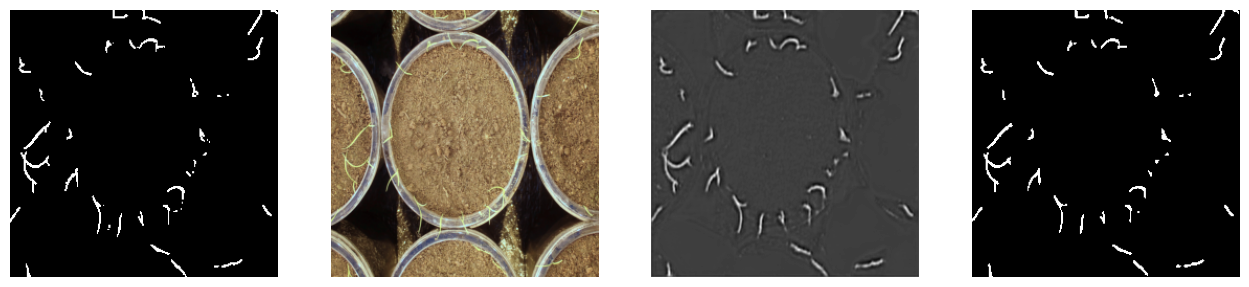

In [22]:
MODEL_PATH = "../models/best_model.pth"

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Running model using {device} device")

# Take a random image from the test dataset
processed_img, processed_mask = niab_dataset[158]

# Create an instance of the model and move it to the device (GPU or CPU) and load the model parameters
model = smp.Unet(
    encoder_name="resnet34",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",  # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,  # model output channels (number of classes in your dataset)
).to(device)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()  # Set model to evaluation mode i.e. doesn't change weights

# Make a prediction
pred = model(processed_img.unsqueeze(0).to(device))

threshold = 0.7
pred_binary = (pred > threshold).float()

# check pred_binary is binary
print(f"Unique values in prediction: {torch.unique(pred_binary)}")

# Plot the image, mask and prediction next to each other
plt.figure(figsize=(20, 10))  # Adjust the width (15) and height (5) as needed

plt.subplot(1, 5, 2)
plt.imshow(processed_mask.cpu().detach().permute(1, 2, 0), cmap="gray")
plt.axis("off")
plt.subplot(1, 5, 3)
plt.imshow(processed_img.cpu().detach().permute(1, 2, 0))
plt.axis("off")
plt.subplot(1, 5, 4)
plt.imshow(pred[0].cpu().detach().permute(1, 2, 0), cmap="gray")
plt.axis("off")
plt.subplot(1, 5, 5)
plt.imshow(
    pred_binary[0].cpu().detach().permute(1, 2, 0), cmap="gray"
)  # quantized after based on prediction estimates
plt.axis("off")

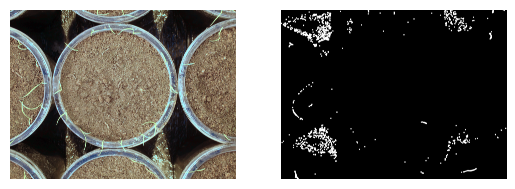

In [21]:
# TODO: Get this working so I can demonstrate the improved performance of the DL approach vs. the HSV approach

# Read processed_img Torch tensor as cv2 image
img = cv2.imread(
    "../datasets/niab/EXP01/Top_Images/Masked_Dataset/imgs/Exp01_Block01_Image04_Pot039.jpg"
)
wb_img, mask = segment_plants(img)

# plot the original image and the mask
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(wb_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="gray")
plt.axis("off")

plt.show()